In [1]:
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [2]:
import torch
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Datasets

In [3]:
# path to train_sets
path = os.path.join('data', 'train_sets', '*', '*.jpg')
fname = glob(path)

# get label for every image
label = [fn.split("/")[-2] for fn in fname]

# get every image
images = [fn.split("/")[-1] for fn in fname]


In [4]:
# get name picture for Label
labels = np.unique(label)
ints = np.arange(0, len(labels))
dicts = dict(zip(labels, ints))

print (dicts)

{'beras_kutah': 0, 'gajah_oling': 1, 'gedegan': 2, 'kopi_pecah': 3, 'moto_pitik': 4, 'paras_gempal': 5, 'sisikan': 6}


In [5]:
# make tabels
df_batik = pd.DataFrame({"image_id":images,"label":label})

#check image files
index = []
path = path[:-7]
for i in range(len(df_batik)) :
    try :
        Image.open(path + str(df_batik["label"][i]) + '/' + str(df_batik["image_id"][i]))
        pass
    except PIL.UnidentifiedImageError:
        index.append(i)

df = df_batik.drop(index)
df.head()

,image_id,label
0,101.jpg,beras_kutah
1,88.jpg,beras_kutah
2,132.jpg,beras_kutah
3,80.jpg,beras_kutah
4,10.jpg,beras_kutah


In [6]:
class Batik(Dataset) :
    def __init__(self, x, y, path, map_label = dicts, transform=None) :
        super().__init__()
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform
    
    def __getitem__(self, idx) :
        img = Image.open(path + str(self.y[idx]) + '/' + str(self.X[idx])).convert("RGB")
        label = self.map_label[self.y[idx]]
        
        if self.transform is not None :
            img = self.transform(img)
        
        return img, label

    
    def __len__(self) :
        return self.X.shape[0]

#### Split data for Train Set and Validation Set

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = df["image_id"].values
y = df["label"].values

# train data, validation data
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.3, shuffle=True, 
                                                          stratify=y, random_state=42)


len(X_train), len(X_val)

(393, 169)

#### dataloader

In [9]:
batch = 16
crop_size = 224

#pipeline data augmentation 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=(10)),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(crop_size + 7),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

# train set and Val_set

train_set = Batik(X_train, y_train, path, transform=train_transform)
val_set = Batik(X_val, y_val, path, transform=val_transform)

# use pytorch for dataloader
train_loader = DataLoader(train_set, batch_size=batch, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch, shuffle=True, 
                        num_workers=4, pin_memory=True)

#### Visualize random image

In [10]:
import random

gedegan


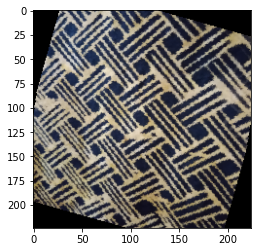

In [11]:
int_label = dict(zip(ints, labels))


img, label = train_set[random.randint(0, len(X_train))]
plt.imshow(img.permute(1,2,0));
print(int_label[label])

# Training

In [12]:
from torch import optim
from tqdm.auto import tqdm

In [13]:
#import models
from Tools.MyModels import CustomResnet152 as myModel

In [14]:
lr = 0.0001

model = myModel().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr= lr)

# print(model)

In [15]:
#function looping
def looping(mode, dataset, dataloader, model, criterion, optimizer, device) :
    if mode =="train" :
        model.train()
    
    elif mode =="val" or mode == "test":
        model.eval()
    
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()) :
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode =="train" :
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    
    return cost, acc

In [16]:
# import EarlyStopping
from Tools.StoppingTools import EarlyStopping

#### Training Process

In [17]:
# Initiate
epochs = 1000
train_cost, val_cost = [], []
train_acc, val_acc = [], []

#object early_stopping
early_stopping = EarlyStopping(patience=40, verbose=True)

for i in range (epochs) :
    since = time.time()
    
    # training for data train
    cost, acc = looping("train", train_set, train_loader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_acc.append(acc)
    
    # training for data val
    with torch.no_grad() :
        cost, acc = looping("val", val_set, val_loader, model, criterion, optimizer, device)
        val_cost.append(cost)
        val_acc.append(acc)
    
    print("Epochs : {}/{} | ".format(i+1, epochs),
          "train_cost : {} | ".format(train_cost[-1]),
          "val_cost : {} | ".format(val_cost[-1]),
          "train_acc : {} | ".format(train_acc[-1]),
          "val_acc : {} | ".format(val_acc[-1]),
          'time {:.3f} s'.format(time.time() - since)
         )
    
    early_stopping(val_cost[-1], model)
    #ealry stopping
    if early_stopping.early_stop:
        print("Early stopping")
        break


Epochs : 1/1000 |  train_cost : 1.880780660165782 |  val_cost : 1.760584961733169 |  train_acc : 0.22900763358778625 |  val_acc : 0.35502958579881655 |  time 503.913 s

Validation loss decreased (inf --> 1.760585).  Saving model ...



Epochs : 2/1000 |  train_cost : 1.6691167673081841 |  val_cost : 1.6020493387470585 |  train_acc : 0.49363867684478374 |  val_acc : 0.5207100591715976 |  time 486.988 s

Validation loss decreased (1.760585 --> 1.602049).  Saving model ...



Epochs : 3/1000 |  train_cost : 1.5160120889430737 |  val_cost : 1.462118428134354 |  train_acc : 0.7175572519083969 |  val_acc : 0.6627218934911243 |  time 477.032 s

Validation loss decreased (1.602049 --> 1.462118).  Saving model ...



Epochs : 4/1000 |  train_cost : 1.3752344679893125 |  val_cost : 1.3481085829480866 |  train_acc : 0.7964376590330788 |  val_acc : 0.757396449704142 |  time 486.638 s

Validation loss decreased (1.462118 --> 1.348109).  Saving model ...



Epochs : 5/1000 |  train_cost : 1.2600969685852983 |  val_cost : 1.2513681135234043 |  train_acc : 0.811704834605598 |  val_acc : 0.8165680473372781 |  time 490.511 s

Validation loss decreased (1.348109 --> 1.251368).  Saving model ...



Epochs : 6/1000 |  train_cost : 1.1522446091241811 |  val_cost : 1.1515601915720652 |  train_acc : 0.8396946564885496 |  val_acc : 0.7988165680473372 |  time 488.114 s

Validation loss decreased (1.251368 --> 1.151560).  Saving model ...



Epochs : 7/1000 |  train_cost : 1.0477585716708622 |  val_cost : 1.0680975653010714 |  train_acc : 0.8651399491094147 |  val_acc : 0.8757396449704142 |  time 491.471 s

Validation loss decreased (1.151560 --> 1.068098).  Saving model ...



Epochs : 8/1000 |  train_cost : 0.9600144453327771 |  val_cost : 0.9852887279183201 |  train_acc : 0.9007633587786259 |  val_acc : 0.8757396449704142 |  time 493.105 s

Validation loss decreased (1.068098 --> 0.985289).  Saving model ...



Epochs : 9/1000 |  train_cost : 0.9050012822369583 |  val_cost : 0.9216636923643259 |  train_acc : 0.8727735368956743 |  val_acc : 0.8875739644970414 |  time 470.256 s

Validation loss decreased (0.985289 --> 0.921664).  Saving model ...



Epochs : 10/1000 |  train_cost : 0.8446216944216468 |  val_cost : 0.8805934423525658 |  train_acc : 0.9236641221374046 |  val_acc : 0.9053254437869822 |  time 467.274 s

Validation loss decreased (0.921664 --> 0.880593).  Saving model ...



Epochs : 11/1000 |  train_cost : 0.7892497338108131 |  val_cost : 0.8465132519338258 |  train_acc : 0.8982188295165394 |  val_acc : 0.8994082840236687 |  time 477.466 s

Validation loss decreased (0.880593 --> 0.846513).  Saving model ...



Epochs : 12/1000 |  train_cost : 0.7546585786130289 |  val_cost : 0.7953482792222288 |  train_acc : 0.9185750636132316 |  val_acc : 0.9171597633136095 |  time 470.121 s

Validation loss decreased (0.846513 --> 0.795348).  Saving model ...



Epochs : 13/1000 |  train_cost : 0.6872301273066882 |  val_cost : 0.766264964137557 |  train_acc : 0.9338422391857506 |  val_acc : 0.9112426035502958 |  time 490.651 s

Validation loss decreased (0.795348 --> 0.766265).  Saving model ...



Epochs : 14/1000 |  train_cost : 0.6467925401134346 |  val_cost : 0.7224597080924807 |  train_acc : 0.9414758269720102 |  val_acc : 0.9230769230769231 |  time 482.810 s

Validation loss decreased (0.766265 --> 0.722460).  Saving model ...



Epochs : 15/1000 |  train_cost : 0.6257343998998782 |  val_cost : 0.6936832701666116 |  train_acc : 0.9287531806615776 |  val_acc : 0.9230769230769231 |  time 481.585 s

Validation loss decreased (0.722460 --> 0.693683).  Saving model ...



Epochs : 16/1000 |  train_cost : 0.5773541076492718 |  val_cost : 0.6774173491805263 |  train_acc : 0.9338422391857506 |  val_acc : 0.9053254437869822 |  time 488.139 s

Validation loss decreased (0.693683 --> 0.677417).  Saving model ...



Epochs : 17/1000 |  train_cost : 0.5611404775056523 |  val_cost : 0.6508748834655129 |  train_acc : 0.9236641221374046 |  val_acc : 0.9053254437869822 |  time 475.623 s

Validation loss decreased (0.677417 --> 0.650875).  Saving model ...



Epochs : 18/1000 |  train_cost : 0.5439399982833377 |  val_cost : 0.6054396830366914 |  train_acc : 0.9465648854961832 |  val_acc : 0.9349112426035503 |  time 479.779 s

Validation loss decreased (0.650875 --> 0.605440).  Saving model ...



Epochs : 19/1000 |  train_cost : 0.5351307021297571 |  val_cost : 0.6082780213045651 |  train_acc : 0.9236641221374046 |  val_acc : 0.9171597633136095 |  time 477.901 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 20/1000 |  train_cost : 0.48997384400768135 |  val_cost : 0.5700618903312458 |  train_acc : 0.9338422391857506 |  val_acc : 0.9349112426035503 |  time 491.173 s

Validation loss decreased (0.605440 --> 0.570062).  Saving model ...



Epochs : 21/1000 |  train_cost : 0.48743992679901704 |  val_cost : 0.5751976215627772 |  train_acc : 0.9414758269720102 |  val_acc : 0.9112426035502958 |  time 475.514 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 22/1000 |  train_cost : 0.45006291496238027 |  val_cost : 0.5637800113336574 |  train_acc : 0.9440203562340967 |  val_acc : 0.9053254437869822 |  time 474.560 s

Validation loss decreased (0.570062 --> 0.563780).  Saving model ...



Epochs : 23/1000 |  train_cost : 0.4480923400580428 |  val_cost : 0.5260678836579858 |  train_acc : 0.9389312977099237 |  val_acc : 0.9289940828402367 |  time 458.505 s

Validation loss decreased (0.563780 --> 0.526068).  Saving model ...



Epochs : 24/1000 |  train_cost : 0.4215516954584583 |  val_cost : 0.51561998668507 |  train_acc : 0.9312977099236641 |  val_acc : 0.9171597633136095 |  time 475.574 s

Validation loss decreased (0.526068 --> 0.515620).  Saving model ...



Epochs : 25/1000 |  train_cost : 0.4406169633222294 |  val_cost : 0.5056005852109582 |  train_acc : 0.9414758269720102 |  val_acc : 0.9289940828402367 |  time 487.658 s

Validation loss decreased (0.515620 --> 0.505601).  Saving model ...



Epochs : 26/1000 |  train_cost : 0.43210724034078857 |  val_cost : 0.5135567539189694 |  train_acc : 0.9389312977099237 |  val_acc : 0.9171597633136095 |  time 468.019 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 27/1000 |  train_cost : 0.40725243698246305 |  val_cost : 0.49844944829771504 |  train_acc : 0.9414758269720102 |  val_acc : 0.9053254437869822 |  time 481.255 s

Validation loss decreased (0.505601 --> 0.498449).  Saving model ...



Epochs : 28/1000 |  train_cost : 0.3830401655523528 |  val_cost : 0.48911647754308035 |  train_acc : 0.9567430025445293 |  val_acc : 0.8994082840236687 |  time 484.934 s

Validation loss decreased (0.498449 --> 0.489116).  Saving model ...



Epochs : 29/1000 |  train_cost : 0.38283484476516566 |  val_cost : 0.4512000237343579 |  train_acc : 0.9389312977099237 |  val_acc : 0.9349112426035503 |  time 479.080 s

Validation loss decreased (0.489116 --> 0.451200).  Saving model ...



Epochs : 30/1000 |  train_cost : 0.3944261661012664 |  val_cost : 0.4498484046501521 |  train_acc : 0.9414758269720102 |  val_acc : 0.9230769230769231 |  time 482.856 s

Validation loss decreased (0.451200 --> 0.449848).  Saving model ...



Epochs : 31/1000 |  train_cost : 0.3594642129866525 |  val_cost : 0.4466356158961911 |  train_acc : 0.9541984732824428 |  val_acc : 0.9349112426035503 |  time 487.932 s

Validation loss decreased (0.449848 --> 0.446636).  Saving model ...



Epochs : 32/1000 |  train_cost : 0.33356033159424636 |  val_cost : 0.42054087752421226 |  train_acc : 0.9414758269720102 |  val_acc : 0.9289940828402367 |  time 475.883 s

Validation loss decreased (0.446636 --> 0.420541).  Saving model ...



Epochs : 33/1000 |  train_cost : 0.3225947215053568 |  val_cost : 0.42874807965826 |  train_acc : 0.9618320610687023 |  val_acc : 0.9171597633136095 |  time 480.016 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 34/1000 |  train_cost : 0.31686460084587564 |  val_cost : 0.45332936246014205 |  train_acc : 0.9669211195928753 |  val_acc : 0.893491124260355 |  time 484.405 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 35/1000 |  train_cost : 0.31193465024763695 |  val_cost : 0.39659194269123865 |  train_acc : 0.9567430025445293 |  val_acc : 0.9289940828402367 |  time 474.405 s

Validation loss decreased (0.420541 --> 0.396592).  Saving model ...



Epochs : 36/1000 |  train_cost : 0.30725799504733875 |  val_cost : 0.3888823333576586 |  train_acc : 0.9592875318066157 |  val_acc : 0.9349112426035503 |  time 480.085 s

Validation loss decreased (0.396592 --> 0.388882).  Saving model ...



Epochs : 37/1000 |  train_cost : 0.30398661072624245 |  val_cost : 0.36030385250875935 |  train_acc : 0.9541984732824428 |  val_acc : 0.9467455621301775 |  time 463.962 s

Validation loss decreased (0.388882 --> 0.360304).  Saving model ...



Epochs : 38/1000 |  train_cost : 0.30514901648950943 |  val_cost : 0.3900780788892825 |  train_acc : 0.9669211195928753 |  val_acc : 0.9349112426035503 |  time 465.996 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 39/1000 |  train_cost : 0.26229869879535744 |  val_cost : 0.3572908569369796 |  train_acc : 0.9821882951653944 |  val_acc : 0.9526627218934911 |  time 472.750 s

Validation loss decreased (0.360304 --> 0.357291).  Saving model ...



Epochs : 40/1000 |  train_cost : 0.3173843217260055 |  val_cost : 0.36778306114603077 |  train_acc : 0.9541984732824428 |  val_acc : 0.9289940828402367 |  time 479.286 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 41/1000 |  train_cost : 0.31064549410767833 |  val_cost : 0.3696972487946234 |  train_acc : 0.9414758269720102 |  val_acc : 0.9408284023668639 |  time 485.829 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 42/1000 |  train_cost : 0.2520237566557246 |  val_cost : 0.36466308669931086 |  train_acc : 0.9745547073791349 |  val_acc : 0.9289940828402367 |  time 470.850 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 43/1000 |  train_cost : 0.2719870247610349 |  val_cost : 0.34151079175034926 |  train_acc : 0.9592875318066157 |  val_acc : 0.9408284023668639 |  time 479.298 s

Validation loss decreased (0.357291 --> 0.341511).  Saving model ...



Epochs : 44/1000 |  train_cost : 0.2473813225598129 |  val_cost : 0.3779654411169199 |  train_acc : 0.9720101781170484 |  val_acc : 0.9112426035502958 |  time 474.824 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 45/1000 |  train_cost : 0.28198805925348636 |  val_cost : 0.3529948409668793 |  train_acc : 0.9567430025445293 |  val_acc : 0.9408284023668639 |  time 481.556 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 46/1000 |  train_cost : 0.24296105787650926 |  val_cost : 0.3444166627861339 |  train_acc : 0.9720101781170484 |  val_acc : 0.9408284023668639 |  time 480.982 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 47/1000 |  train_cost : 0.22941809263241503 |  val_cost : 0.3419373056592321 |  train_acc : 0.9745547073791349 |  val_acc : 0.9408284023668639 |  time 475.929 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 48/1000 |  train_cost : 0.22617191409943366 |  val_cost : 0.3394820478540906 |  train_acc : 0.9770992366412213 |  val_acc : 0.9349112426035503 |  time 481.287 s

Validation loss decreased (0.341511 --> 0.339482).  Saving model ...



Epochs : 49/1000 |  train_cost : 0.2607900917378394 |  val_cost : 0.323422024412268 |  train_acc : 0.9592875318066157 |  val_acc : 0.9408284023668639 |  time 466.407 s

Validation loss decreased (0.339482 --> 0.323422).  Saving model ...



Epochs : 50/1000 |  train_cost : 0.2475482998155152 |  val_cost : 0.3395380622007438 |  train_acc : 0.9694656488549618 |  val_acc : 0.9289940828402367 |  time 493.837 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 51/1000 |  train_cost : 0.2381336674587114 |  val_cost : 0.3239003857211954 |  train_acc : 0.9643765903307888 |  val_acc : 0.9467455621301775 |  time 478.711 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 52/1000 |  train_cost : 0.22878792965381806 |  val_cost : 0.3426011169450523 |  train_acc : 0.9770992366412213 |  val_acc : 0.9408284023668639 |  time 476.877 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 53/1000 |  train_cost : 0.22817634599657763 |  val_cost : 0.29462858417330406 |  train_acc : 0.9694656488549618 |  val_acc : 0.9408284023668639 |  time 484.232 s

Validation loss decreased (0.323422 --> 0.294629).  Saving model ...



Epochs : 54/1000 |  train_cost : 0.2268562061337721 |  val_cost : 0.32465501279520564 |  train_acc : 0.9745547073791349 |  val_acc : 0.9408284023668639 |  time 474.689 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 55/1000 |  train_cost : 0.2254531291756618 |  val_cost : 0.3297763419221844 |  train_acc : 0.9669211195928753 |  val_acc : 0.9289940828402367 |  time 477.094 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 56/1000 |  train_cost : 0.20533992570016826 |  val_cost : 0.2961260523845458 |  train_acc : 0.9720101781170484 |  val_acc : 0.9408284023668639 |  time 464.856 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 57/1000 |  train_cost : 0.19998388481504134 |  val_cost : 0.3221649591033981 |  train_acc : 0.9796437659033079 |  val_acc : 0.9230769230769231 |  time 476.152 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 58/1000 |  train_cost : 0.20375502666899267 |  val_cost : 0.31704574311978717 |  train_acc : 0.9745547073791349 |  val_acc : 0.9289940828402367 |  time 482.643 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 59/1000 |  train_cost : 0.183168950123338 |  val_cost : 0.3005022224942608 |  train_acc : 0.9949109414758269 |  val_acc : 0.9112426035502958 |  time 482.810 s

 |EarlyStopping counter: 6 out of 40|



Epochs : 60/1000 |  train_cost : 0.16619878453759443 |  val_cost : 0.2743607891734535 |  train_acc : 0.989821882951654 |  val_acc : 0.9467455621301775 |  time 475.241 s

Validation loss decreased (0.294629 --> 0.274361).  Saving model ...



Epochs : 61/1000 |  train_cost : 0.20611755193493142 |  val_cost : 0.27735962934747954 |  train_acc : 0.9618320610687023 |  val_acc : 0.9467455621301775 |  time 475.816 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 62/1000 |  train_cost : 0.20575109651222181 |  val_cost : 0.28734044175176227 |  train_acc : 0.9694656488549618 |  val_acc : 0.9408284023668639 |  time 473.156 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 63/1000 |  train_cost : 0.17660015351293046 |  val_cost : 0.2795180440301726 |  train_acc : 0.9720101781170484 |  val_acc : 0.9408284023668639 |  time 483.403 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 64/1000 |  train_cost : 0.20428691550368874 |  val_cost : 0.28409631947088526 |  train_acc : 0.9745547073791349 |  val_acc : 0.9467455621301775 |  time 480.835 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 65/1000 |  train_cost : 0.1703399765582485 |  val_cost : 0.2828278553027373 |  train_acc : 0.9770992366412213 |  val_acc : 0.9408284023668639 |  time 480.477 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 66/1000 |  train_cost : 0.21501566602376884 |  val_cost : 0.3144090631480753 |  train_acc : 0.9592875318066157 |  val_acc : 0.9289940828402367 |  time 474.669 s

 |EarlyStopping counter: 6 out of 40|



Epochs : 67/1000 |  train_cost : 0.19421343888338588 |  val_cost : 0.2631896187567852 |  train_acc : 0.9694656488549618 |  val_acc : 0.9526627218934911 |  time 478.126 s

Validation loss decreased (0.274361 --> 0.263190).  Saving model ...



Epochs : 68/1000 |  train_cost : 0.18342845278386852 |  val_cost : 0.2748941359435313 |  train_acc : 0.9770992366412213 |  val_acc : 0.9408284023668639 |  time 483.828 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 69/1000 |  train_cost : 0.20391893974545652 |  val_cost : 0.26841100151016867 |  train_acc : 0.9669211195928753 |  val_acc : 0.9526627218934911 |  time 496.152 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 70/1000 |  train_cost : 0.1614941673272742 |  val_cost : 0.24595827375643353 |  train_acc : 0.9821882951653944 |  val_acc : 0.9349112426035503 |  time 481.111 s

Validation loss decreased (0.263190 --> 0.245958).  Saving model ...



Epochs : 71/1000 |  train_cost : 0.1569035135342268 |  val_cost : 0.27013848325204565 |  train_acc : 0.9821882951653944 |  val_acc : 0.9467455621301775 |  time 477.544 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 72/1000 |  train_cost : 0.18126908729549582 |  val_cost : 0.244620461435713 |  train_acc : 0.9669211195928753 |  val_acc : 0.9526627218934911 |  time 477.513 s

Validation loss decreased (0.245958 --> 0.244620).  Saving model ...



Epochs : 73/1000 |  train_cost : 0.15211217450428252 |  val_cost : 0.24047010704963165 |  train_acc : 0.9923664122137404 |  val_acc : 0.9408284023668639 |  time 486.372 s

Validation loss decreased (0.244620 --> 0.240470).  Saving model ...



Epochs : 74/1000 |  train_cost : 0.15634091334943553 |  val_cost : 0.2609450626655443 |  train_acc : 0.9872773536895675 |  val_acc : 0.9408284023668639 |  time 478.946 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 75/1000 |  train_cost : 0.19278830797921004 |  val_cost : 0.23441649135753248 |  train_acc : 0.9694656488549618 |  val_acc : 0.9467455621301775 |  time 487.407 s

Validation loss decreased (0.240470 --> 0.234416).  Saving model ...



Epochs : 76/1000 |  train_cost : 0.1701582486696219 |  val_cost : 0.24945643702907674 |  train_acc : 0.9669211195928753 |  val_acc : 0.9526627218934911 |  time 467.973 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 77/1000 |  train_cost : 0.17253261216875856 |  val_cost : 0.24397612861274967 |  train_acc : 0.9669211195928753 |  val_acc : 0.9408284023668639 |  time 486.696 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 78/1000 |  train_cost : 0.1695872895969386 |  val_cost : 0.22744307168842068 |  train_acc : 0.9720101781170484 |  val_acc : 0.9585798816568047 |  time 484.627 s

Validation loss decreased (0.234416 --> 0.227443).  Saving model ...



Epochs : 79/1000 |  train_cost : 0.18794448867098976 |  val_cost : 0.24945467781033037 |  train_acc : 0.9694656488549618 |  val_acc : 0.9408284023668639 |  time 478.370 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 80/1000 |  train_cost : 0.1395048540246699 |  val_cost : 0.2816707574756893 |  train_acc : 0.9821882951653944 |  val_acc : 0.9289940828402367 |  time 470.756 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 81/1000 |  train_cost : 0.13807398869487772 |  val_cost : 0.25833628816012094 |  train_acc : 0.9872773536895675 |  val_acc : 0.9467455621301775 |  time 479.571 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 82/1000 |  train_cost : 0.15955456135837176 |  val_cost : 0.26420421801375216 |  train_acc : 0.9847328244274809 |  val_acc : 0.9230769230769231 |  time 492.607 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 83/1000 |  train_cost : 0.15151104406849422 |  val_cost : 0.2646819839816122 |  train_acc : 0.9770992366412213 |  val_acc : 0.9349112426035503 |  time 471.956 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 84/1000 |  train_cost : 0.1859413104809574 |  val_cost : 0.25222454162744373 |  train_acc : 0.9643765903307888 |  val_acc : 0.9349112426035503 |  time 469.463 s

 |EarlyStopping counter: 6 out of 40|



Epochs : 85/1000 |  train_cost : 0.14091326516244854 |  val_cost : 0.24412654190373845 |  train_acc : 0.9770992366412213 |  val_acc : 0.9467455621301775 |  time 469.906 s

 |EarlyStopping counter: 7 out of 40|



Epochs : 86/1000 |  train_cost : 0.1327820279974367 |  val_cost : 0.21807557379705667 |  train_acc : 0.9949109414758269 |  val_acc : 0.9467455621301775 |  time 463.130 s

Validation loss decreased (0.227443 --> 0.218076).  Saving model ...



Epochs : 87/1000 |  train_cost : 0.12872527816520088 |  val_cost : 0.23303774387173398 |  train_acc : 0.9821882951653944 |  val_acc : 0.9585798816568047 |  time 468.892 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 88/1000 |  train_cost : 0.1462037878409597 |  val_cost : 0.21943590697452162 |  train_acc : 0.9847328244274809 |  val_acc : 0.9585798816568047 |  time 480.751 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 89/1000 |  train_cost : 0.133651627099696 |  val_cost : 0.21994227400192848 |  train_acc : 0.989821882951654 |  val_acc : 0.9349112426035503 |  time 476.780 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 90/1000 |  train_cost : 0.1286468907394482 |  val_cost : 0.24742090790229437 |  train_acc : 0.9923664122137404 |  val_acc : 0.9230769230769231 |  time 469.823 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 91/1000 |  train_cost : 0.13790817164434427 |  val_cost : 0.2516015222924348 |  train_acc : 0.9796437659033079 |  val_acc : 0.9349112426035503 |  time 462.803 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 92/1000 |  train_cost : 0.11611268642825329 |  val_cost : 0.20014447079607722 |  train_acc : 0.9872773536895675 |  val_acc : 0.9585798816568047 |  time 473.756 s

Validation loss decreased (0.218076 --> 0.200144).  Saving model ...



Epochs : 93/1000 |  train_cost : 0.1257769890110608 |  val_cost : 0.21742975817629573 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 465.868 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 94/1000 |  train_cost : 0.1493749903282743 |  val_cost : 0.2533627524531099 |  train_acc : 0.9796437659033079 |  val_acc : 0.9230769230769231 |  time 460.068 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 95/1000 |  train_cost : 0.12815511890191764 |  val_cost : 0.19490331032219724 |  train_acc : 0.9821882951653944 |  val_acc : 0.9585798816568047 |  time 468.820 s

Validation loss decreased (0.200144 --> 0.194903).  Saving model ...



Epochs : 96/1000 |  train_cost : 0.12685836722680935 |  val_cost : 0.2109110951423645 |  train_acc : 0.9949109414758269 |  val_acc : 0.9585798816568047 |  time 483.686 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 97/1000 |  train_cost : 0.10925311339265517 |  val_cost : 0.2507281754849225 |  train_acc : 0.9796437659033079 |  val_acc : 0.9289940828402367 |  time 468.194 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 98/1000 |  train_cost : 0.11889633953419654 |  val_cost : 0.2145660307985791 |  train_acc : 0.9745547073791349 |  val_acc : 0.9526627218934911 |  time 469.051 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 99/1000 |  train_cost : 0.11595811499590788 |  val_cost : 0.2179707080654844 |  train_acc : 0.9847328244274809 |  val_acc : 0.9349112426035503 |  time 469.871 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 100/1000 |  train_cost : 0.1304502353906328 |  val_cost : 0.2163252271491395 |  train_acc : 0.989821882951654 |  val_acc : 0.9408284023668639 |  time 468.126 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 101/1000 |  train_cost : 0.1131948215209194 |  val_cost : 0.2227397343287101 |  train_acc : 0.989821882951654 |  val_acc : 0.9289940828402367 |  time 467.511 s

 |EarlyStopping counter: 6 out of 40|



Epochs : 102/1000 |  train_cost : 0.1213910170183837 |  val_cost : 0.19210346629457362 |  train_acc : 0.9821882951653944 |  val_acc : 0.9644970414201184 |  time 469.434 s

Validation loss decreased (0.194903 --> 0.192103).  Saving model ...



Epochs : 103/1000 |  train_cost : 0.12364437999843642 |  val_cost : 0.21943298872758651 |  train_acc : 0.9821882951653944 |  val_acc : 0.9526627218934911 |  time 469.405 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 104/1000 |  train_cost : 0.1250141760850984 |  val_cost : 0.17760732461362194 |  train_acc : 0.9847328244274809 |  val_acc : 0.9644970414201184 |  time 463.482 s

Validation loss decreased (0.192103 --> 0.177607).  Saving model ...



Epochs : 105/1000 |  train_cost : 0.11093419202563114 |  val_cost : 0.2195514805570862 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 465.320 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 106/1000 |  train_cost : 0.10524170216334078 |  val_cost : 0.20063236338147045 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 462.620 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 107/1000 |  train_cost : 0.0990694635393662 |  val_cost : 0.18222341812133083 |  train_acc : 0.9923664122137404 |  val_acc : 0.9585798816568047 |  time 462.213 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 108/1000 |  train_cost : 0.11806859906393154 |  val_cost : 0.24044454626783113 |  train_acc : 0.9847328244274809 |  val_acc : 0.9408284023668639 |  time 466.302 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 109/1000 |  train_cost : 0.11912334716047039 |  val_cost : 0.23092771638956297 |  train_acc : 0.9923664122137404 |  val_acc : 0.9408284023668639 |  time 482.263 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 110/1000 |  train_cost : 0.10777306059996287 |  val_cost : 0.23145340883432056 |  train_acc : 0.9847328244274809 |  val_acc : 0.9349112426035503 |  time 469.793 s

 |EarlyStopping counter: 6 out of 40|



Epochs : 111/1000 |  train_cost : 0.12263336322689784 |  val_cost : 0.21985293598570063 |  train_acc : 0.9796437659033079 |  val_acc : 0.9585798816568047 |  time 486.096 s

 |EarlyStopping counter: 7 out of 40|



Epochs : 112/1000 |  train_cost : 0.11880320141864491 |  val_cost : 0.20208171133458966 |  train_acc : 0.9745547073791349 |  val_acc : 0.9585798816568047 |  time 486.049 s

 |EarlyStopping counter: 8 out of 40|



Epochs : 113/1000 |  train_cost : 0.10585042788782192 |  val_cost : 0.1839014213951029 |  train_acc : 0.9923664122137404 |  val_acc : 0.9644970414201184 |  time 473.040 s

 |EarlyStopping counter: 9 out of 40|



Epochs : 114/1000 |  train_cost : 0.11915405463360952 |  val_cost : 0.18073607469804187 |  train_acc : 0.9872773536895675 |  val_acc : 0.9585798816568047 |  time 464.041 s

 |EarlyStopping counter: 10 out of 40|



Epochs : 115/1000 |  train_cost : 0.11673838374117251 |  val_cost : 0.2057612263239347 |  train_acc : 0.9796437659033079 |  val_acc : 0.9526627218934911 |  time 473.180 s

 |EarlyStopping counter: 11 out of 40|



Epochs : 116/1000 |  train_cost : 0.102286879608346 |  val_cost : 0.23118777828809073 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 473.371 s

 |EarlyStopping counter: 12 out of 40|



Epochs : 117/1000 |  train_cost : 0.08574731883050224 |  val_cost : 0.1930340310701957 |  train_acc : 0.9949109414758269 |  val_acc : 0.9467455621301775 |  time 462.806 s

 |EarlyStopping counter: 13 out of 40|



Epochs : 118/1000 |  train_cost : 0.10044613302360661 |  val_cost : 0.20916486862143116 |  train_acc : 0.989821882951654 |  val_acc : 0.9408284023668639 |  time 473.560 s

 |EarlyStopping counter: 14 out of 40|



Epochs : 119/1000 |  train_cost : 0.09043165218587443 |  val_cost : 0.2111017658160283 |  train_acc : 1.0 |  val_acc : 0.9526627218934911 |  time 476.177 s

 |EarlyStopping counter: 15 out of 40|



Epochs : 120/1000 |  train_cost : 0.10089540580150129 |  val_cost : 0.22088063883005515 |  train_acc : 0.9847328244274809 |  val_acc : 0.9526627218934911 |  time 457.062 s

 |EarlyStopping counter: 16 out of 40|



Epochs : 121/1000 |  train_cost : 0.10648930398865813 |  val_cost : 0.17722515947014622 |  train_acc : 0.9923664122137404 |  val_acc : 0.9467455621301775 |  time 462.261 s

Validation loss decreased (0.177607 --> 0.177225).  Saving model ...



Epochs : 122/1000 |  train_cost : 0.09743476387956973 |  val_cost : 0.24320488771390633 |  train_acc : 0.989821882951654 |  val_acc : 0.9289940828402367 |  time 463.221 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 123/1000 |  train_cost : 0.09061690433183092 |  val_cost : 0.18218071838102398 |  train_acc : 0.9923664122137404 |  val_acc : 0.9644970414201184 |  time 468.974 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 124/1000 |  train_cost : 0.1299366333709115 |  val_cost : 0.1836553173657705 |  train_acc : 0.9694656488549618 |  val_acc : 0.9644970414201184 |  time 466.925 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 125/1000 |  train_cost : 0.11271579087766376 |  val_cost : 0.20930704556008767 |  train_acc : 0.9796437659033079 |  val_acc : 0.9408284023668639 |  time 483.941 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 126/1000 |  train_cost : 0.09206911591628125 |  val_cost : 0.1858885590670377 |  train_acc : 0.989821882951654 |  val_acc : 0.9467455621301775 |  time 480.626 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 127/1000 |  train_cost : 0.09644138608270018 |  val_cost : 0.18124883097304395 |  train_acc : 0.9847328244274809 |  val_acc : 0.9526627218934911 |  time 492.456 s

 |EarlyStopping counter: 6 out of 40|



Epochs : 128/1000 |  train_cost : 0.08306969577119551 |  val_cost : 0.17792532764948332 |  train_acc : 0.9872773536895675 |  val_acc : 0.9585798816568047 |  time 487.996 s

 |EarlyStopping counter: 7 out of 40|



Epochs : 129/1000 |  train_cost : 0.09635082418075348 |  val_cost : 0.18459024055469672 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 469.920 s

 |EarlyStopping counter: 8 out of 40|



Epochs : 130/1000 |  train_cost : 0.0973536410954314 |  val_cost : 0.17274176360234705 |  train_acc : 0.9847328244274809 |  val_acc : 0.9467455621301775 |  time 478.438 s

Validation loss decreased (0.177225 --> 0.172742).  Saving model ...



Epochs : 131/1000 |  train_cost : 0.1228577282289209 |  val_cost : 0.19428176163921695 |  train_acc : 0.9821882951653944 |  val_acc : 0.9467455621301775 |  time 472.477 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 132/1000 |  train_cost : 0.11577944017700263 |  val_cost : 0.2236501914201051 |  train_acc : 0.9745547073791349 |  val_acc : 0.9408284023668639 |  time 473.512 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 133/1000 |  train_cost : 0.09398860133634572 |  val_cost : 0.1670433211873269 |  train_acc : 0.9872773536895675 |  val_acc : 0.9526627218934911 |  time 478.153 s

Validation loss decreased (0.172742 --> 0.167043).  Saving model ...



Epochs : 134/1000 |  train_cost : 0.09843536875857652 |  val_cost : 0.17233426644075553 |  train_acc : 0.989821882951654 |  val_acc : 0.9467455621301775 |  time 482.178 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 135/1000 |  train_cost : 0.09079422219715652 |  val_cost : 0.16560021430783017 |  train_acc : 0.9923664122137404 |  val_acc : 0.9467455621301775 |  time 482.593 s

Validation loss decreased (0.167043 --> 0.165600).  Saving model ...



Epochs : 136/1000 |  train_cost : 0.08395758712943881 |  val_cost : 0.21686114555985264 |  train_acc : 0.9872773536895675 |  val_acc : 0.9289940828402367 |  time 488.894 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 137/1000 |  train_cost : 0.09313359109651648 |  val_cost : 0.1961189136349943 |  train_acc : 0.9872773536895675 |  val_acc : 0.9349112426035503 |  time 487.252 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 138/1000 |  train_cost : 0.08581441151731797 |  val_cost : 0.19184315107630553 |  train_acc : 0.9923664122137404 |  val_acc : 0.9467455621301775 |  time 482.263 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 139/1000 |  train_cost : 0.10419851268520793 |  val_cost : 0.19878699537917707 |  train_acc : 0.9847328244274809 |  val_acc : 0.9644970414201184 |  time 492.742 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 140/1000 |  train_cost : 0.08456806379723489 |  val_cost : 0.1589151655252163 |  train_acc : 0.989821882951654 |  val_acc : 0.9644970414201184 |  time 491.336 s

Validation loss decreased (0.165600 --> 0.158915).  Saving model ...



Epochs : 141/1000 |  train_cost : 0.0971258977669796 |  val_cost : 0.17844618416044133 |  train_acc : 0.9872773536895675 |  val_acc : 0.9467455621301775 |  time 489.466 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 142/1000 |  train_cost : 0.08672574355857063 |  val_cost : 0.17136573738600375 |  train_acc : 0.9923664122137404 |  val_acc : 0.9644970414201184 |  time 493.036 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 143/1000 |  train_cost : 0.08999245084879053 |  val_cost : 0.21827611926744675 |  train_acc : 0.989821882951654 |  val_acc : 0.9289940828402367 |  time 496.992 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 144/1000 |  train_cost : 0.07049356298592255 |  val_cost : 0.14743748677552804 |  train_acc : 0.9923664122137404 |  val_acc : 0.9704142011834319 |  time 517.012 s

Validation loss decreased (0.158915 --> 0.147437).  Saving model ...



Epochs : 145/1000 |  train_cost : 0.09241912011578489 |  val_cost : 0.21695416689624447 |  train_acc : 0.9872773536895675 |  val_acc : 0.9467455621301775 |  time 499.093 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 146/1000 |  train_cost : 0.08458216545236019 |  val_cost : 0.18928370820964582 |  train_acc : 0.9821882951653944 |  val_acc : 0.9526627218934911 |  time 496.142 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 147/1000 |  train_cost : 0.07795803225658474 |  val_cost : 0.1974684742428142 |  train_acc : 0.9923664122137404 |  val_acc : 0.9349112426035503 |  time 497.126 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 148/1000 |  train_cost : 0.08236977518666488 |  val_cost : 0.1900816508651485 |  train_acc : 0.9923664122137404 |  val_acc : 0.9585798816568047 |  time 486.278 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 149/1000 |  train_cost : 0.0923271528788802 |  val_cost : 0.17520915346561805 |  train_acc : 0.9847328244274809 |  val_acc : 0.9644970414201184 |  time 479.406 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 150/1000 |  train_cost : 0.09212202978801484 |  val_cost : 0.17576742811492208 |  train_acc : 0.9872773536895675 |  val_acc : 0.9644970414201184 |  time 484.181 s

 |EarlyStopping counter: 6 out of 40|



Epochs : 151/1000 |  train_cost : 0.07693131840562699 |  val_cost : 0.18355104856237153 |  train_acc : 0.9949109414758269 |  val_acc : 0.9526627218934911 |  time 479.239 s

 |EarlyStopping counter: 7 out of 40|



Epochs : 152/1000 |  train_cost : 0.07277915435286272 |  val_cost : 0.16703124401661065 |  train_acc : 0.9949109414758269 |  val_acc : 0.9585798816568047 |  time 489.976 s

 |EarlyStopping counter: 8 out of 40|



Epochs : 153/1000 |  train_cost : 0.08045369890961634 |  val_cost : 0.18358184542705322 |  train_acc : 0.989821882951654 |  val_acc : 0.9585798816568047 |  time 492.985 s

 |EarlyStopping counter: 9 out of 40|



Epochs : 154/1000 |  train_cost : 0.1098158205018092 |  val_cost : 0.21615866386502453 |  train_acc : 0.9821882951653944 |  val_acc : 0.9408284023668639 |  time 496.504 s

 |EarlyStopping counter: 10 out of 40|



Epochs : 155/1000 |  train_cost : 0.1044691669785491 |  val_cost : 0.17368075727711063 |  train_acc : 0.9796437659033079 |  val_acc : 0.9585798816568047 |  time 501.528 s

 |EarlyStopping counter: 11 out of 40|



Epochs : 156/1000 |  train_cost : 0.09049489927352536 |  val_cost : 0.16922720790614743 |  train_acc : 0.9872773536895675 |  val_acc : 0.9585798816568047 |  time 493.276 s

 |EarlyStopping counter: 12 out of 40|



Epochs : 157/1000 |  train_cost : 0.07902247813215085 |  val_cost : 0.15121044227357447 |  train_acc : 0.9974554707379135 |  val_acc : 0.9526627218934911 |  time 494.060 s

 |EarlyStopping counter: 13 out of 40|



Epochs : 158/1000 |  train_cost : 0.07505679471802165 |  val_cost : 0.17926961289355037 |  train_acc : 0.9872773536895675 |  val_acc : 0.9526627218934911 |  time 499.313 s

 |EarlyStopping counter: 14 out of 40|



Epochs : 159/1000 |  train_cost : 0.08151260825968881 |  val_cost : 0.1876412279154422 |  train_acc : 0.9847328244274809 |  val_acc : 0.9585798816568047 |  time 508.208 s

 |EarlyStopping counter: 15 out of 40|



Epochs : 160/1000 |  train_cost : 0.07634117069438517 |  val_cost : 0.14763201438110962 |  train_acc : 0.9821882951653944 |  val_acc : 0.9585798816568047 |  time 480.483 s

 |EarlyStopping counter: 16 out of 40|



Epochs : 161/1000 |  train_cost : 0.0845346512135507 |  val_cost : 0.20543812329952532 |  train_acc : 0.989821882951654 |  val_acc : 0.9349112426035503 |  time 490.429 s

 |EarlyStopping counter: 17 out of 40|



Epochs : 162/1000 |  train_cost : 0.06912439030242026 |  val_cost : 0.20238235107893068 |  train_acc : 0.9949109414758269 |  val_acc : 0.9526627218934911 |  time 507.661 s

 |EarlyStopping counter: 18 out of 40|



Epochs : 163/1000 |  train_cost : 0.07445255384493724 |  val_cost : 0.18378750547854858 |  train_acc : 0.9923664122137404 |  val_acc : 0.9467455621301775 |  time 504.980 s

 |EarlyStopping counter: 19 out of 40|



Epochs : 164/1000 |  train_cost : 0.0756737443857824 |  val_cost : 0.17501700766516862 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 490.037 s

 |EarlyStopping counter: 20 out of 40|



Epochs : 165/1000 |  train_cost : 0.09058336833961138 |  val_cost : 0.16352735437761398 |  train_acc : 0.9796437659033079 |  val_acc : 0.9526627218934911 |  time 501.538 s

 |EarlyStopping counter: 21 out of 40|



Epochs : 166/1000 |  train_cost : 0.0734323610767305 |  val_cost : 0.16564226044705632 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 500.769 s

 |EarlyStopping counter: 22 out of 40|



Epochs : 167/1000 |  train_cost : 0.05706165826692229 |  val_cost : 0.14344766647858026 |  train_acc : 0.9949109414758269 |  val_acc : 0.9585798816568047 |  time 496.791 s

Validation loss decreased (0.147437 --> 0.143448).  Saving model ...



Epochs : 168/1000 |  train_cost : 0.0722552977748803 |  val_cost : 0.1604846285645073 |  train_acc : 0.989821882951654 |  val_acc : 0.9585798816568047 |  time 491.290 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 169/1000 |  train_cost : 0.07636810630635754 |  val_cost : 0.18015536859896056 |  train_acc : 0.9872773536895675 |  val_acc : 0.9467455621301775 |  time 506.499 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 170/1000 |  train_cost : 0.06565833027277891 |  val_cost : 0.16143559360292536 |  train_acc : 0.9923664122137404 |  val_acc : 0.9585798816568047 |  time 513.078 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 171/1000 |  train_cost : 0.06748337664525321 |  val_cost : 0.15930701712884845 |  train_acc : 0.9923664122137404 |  val_acc : 0.9585798816568047 |  time 486.710 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 172/1000 |  train_cost : 0.08762259696048634 |  val_cost : 0.1482439755335362 |  train_acc : 0.9821882951653944 |  val_acc : 0.9526627218934911 |  time 485.968 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 173/1000 |  train_cost : 0.07992404964740646 |  val_cost : 0.18203814724493309 |  train_acc : 0.9847328244274809 |  val_acc : 0.9585798816568047 |  time 481.322 s

 |EarlyStopping counter: 6 out of 40|



Epochs : 174/1000 |  train_cost : 0.10292814853992172 |  val_cost : 0.1300298009707025 |  train_acc : 0.9745547073791349 |  val_acc : 0.9704142011834319 |  time 482.236 s

Validation loss decreased (0.143448 --> 0.130030).  Saving model ...



Epochs : 175/1000 |  train_cost : 0.07165896313847932 |  val_cost : 0.18405422797569862 |  train_acc : 0.989821882951654 |  val_acc : 0.9408284023668639 |  time 486.542 s

 |EarlyStopping counter: 1 out of 40|



Epochs : 176/1000 |  train_cost : 0.08936664295257199 |  val_cost : 0.15145782500329102 |  train_acc : 0.9847328244274809 |  val_acc : 0.9526627218934911 |  time 493.251 s

 |EarlyStopping counter: 2 out of 40|



Epochs : 177/1000 |  train_cost : 0.07519111041045977 |  val_cost : 0.1747052084059405 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 476.517 s

 |EarlyStopping counter: 3 out of 40|



Epochs : 178/1000 |  train_cost : 0.057949755075399505 |  val_cost : 0.17896606142704302 |  train_acc : 0.9974554707379135 |  val_acc : 0.9526627218934911 |  time 487.150 s

 |EarlyStopping counter: 4 out of 40|



Epochs : 179/1000 |  train_cost : 0.06312754409003804 |  val_cost : 0.1738586672664394 |  train_acc : 0.9949109414758269 |  val_acc : 0.9526627218934911 |  time 483.131 s

 |EarlyStopping counter: 5 out of 40|



Epochs : 180/1000 |  train_cost : 0.05136588560867552 |  val_cost : 0.15001970115145283 |  train_acc : 0.9974554707379135 |  val_acc : 0.9585798816568047 |  time 476.251 s

 |EarlyStopping counter: 6 out of 40|



Epochs : 181/1000 |  train_cost : 0.07820129777487302 |  val_cost : 0.15585412146777092 |  train_acc : 0.9770992366412213 |  val_acc : 0.9526627218934911 |  time 504.842 s

 |EarlyStopping counter: 7 out of 40|



Epochs : 182/1000 |  train_cost : 0.07255551892003334 |  val_cost : 0.15987035491057403 |  train_acc : 0.9821882951653944 |  val_acc : 0.9585798816568047 |  time 498.779 s

 |EarlyStopping counter: 8 out of 40|



Epochs : 183/1000 |  train_cost : 0.07206435751823978 |  val_cost : 0.16264188386632142 |  train_acc : 0.9872773536895675 |  val_acc : 0.9644970414201184 |  time 489.379 s

 |EarlyStopping counter: 9 out of 40|



Epochs : 184/1000 |  train_cost : 0.06956795130977193 |  val_cost : 0.16651577469424383 |  train_acc : 0.989821882951654 |  val_acc : 0.9526627218934911 |  time 512.283 s

 |EarlyStopping counter: 10 out of 40|



Epochs : 185/1000 |  train_cost : 0.05617445305406896 |  val_cost : 0.1793718133452376 |  train_acc : 0.9949109414758269 |  val_acc : 0.9467455621301775 |  time 488.397 s

 |EarlyStopping counter: 11 out of 40|



Epochs : 186/1000 |  train_cost : 0.060317285548487996 |  val_cost : 0.14368438841940384 |  train_acc : 0.989821882951654 |  val_acc : 0.9526627218934911 |  time 480.488 s

 |EarlyStopping counter: 12 out of 40|



Epochs : 187/1000 |  train_cost : 0.092703417967294 |  val_cost : 0.1470197191428856 |  train_acc : 0.9847328244274809 |  val_acc : 0.9644970414201184 |  time 484.448 s

 |EarlyStopping counter: 13 out of 40|



Epochs : 188/1000 |  train_cost : 0.06850975058005966 |  val_cost : 0.16154503099311737 |  train_acc : 0.9949109414758269 |  val_acc : 0.9585798816568047 |  time 474.910 s

 |EarlyStopping counter: 14 out of 40|



Epochs : 189/1000 |  train_cost : 0.07248181662031712 |  val_cost : 0.17209006669605978 |  train_acc : 0.9949109414758269 |  val_acc : 0.9585798816568047 |  time 478.706 s

 |EarlyStopping counter: 15 out of 40|



Epochs : 190/1000 |  train_cost : 0.07264893192978002 |  val_cost : 0.15318176503012165 |  train_acc : 0.9923664122137404 |  val_acc : 0.9585798816568047 |  time 481.220 s

 |EarlyStopping counter: 16 out of 40|



Epochs : 191/1000 |  train_cost : 0.06637246265969507 |  val_cost : 0.1496026242240029 |  train_acc : 0.9949109414758269 |  val_acc : 0.9585798816568047 |  time 482.243 s

 |EarlyStopping counter: 17 out of 40|



Epochs : 192/1000 |  train_cost : 0.06876147896733903 |  val_cost : 0.16363041288048558 |  train_acc : 0.989821882951654 |  val_acc : 0.9526627218934911 |  time 488.544 s

 |EarlyStopping counter: 18 out of 40|



Epochs : 193/1000 |  train_cost : 0.059602209800527294 |  val_cost : 0.15621330082063845 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 478.681 s

 |EarlyStopping counter: 19 out of 40|



Epochs : 194/1000 |  train_cost : 0.06910042505019343 |  val_cost : 0.15126937292736664 |  train_acc : 0.9923664122137404 |  val_acc : 0.9526627218934911 |  time 485.930 s

 |EarlyStopping counter: 20 out of 40|



Epochs : 195/1000 |  train_cost : 0.07283427402301296 |  val_cost : 0.1334642030783659 |  train_acc : 0.9872773536895675 |  val_acc : 0.9585798816568047 |  time 486.253 s

 |EarlyStopping counter: 21 out of 40|



Epochs : 196/1000 |  train_cost : 0.058943761138212286 |  val_cost : 0.16825629479786347 |  train_acc : 0.9949109414758269 |  val_acc : 0.9526627218934911 |  time 488.354 s

 |EarlyStopping counter: 22 out of 40|



Epochs : 197/1000 |  train_cost : 0.060005075528118144 |  val_cost : 0.15823378506496813 |  train_acc : 0.989821882951654 |  val_acc : 0.9526627218934911 |  time 491.814 s

 |EarlyStopping counter: 23 out of 40|



Epochs : 198/1000 |  train_cost : 0.06267767122759467 |  val_cost : 0.15221396070965648 |  train_acc : 0.9949109414758269 |  val_acc : 0.9644970414201184 |  time 484.713 s

 |EarlyStopping counter: 24 out of 40|



Epochs : 199/1000 |  train_cost : 0.0653378761186248 |  val_cost : 0.13817799995107763 |  train_acc : 0.9923664122137404 |  val_acc : 0.9644970414201184 |  time 487.117 s

 |EarlyStopping counter: 25 out of 40|



Epochs : 200/1000 |  train_cost : 0.06621218273657879 |  val_cost : 0.16868622620871082 |  train_acc : 0.9872773536895675 |  val_acc : 0.9585798816568047 |  time 487.256 s

 |EarlyStopping counter: 26 out of 40|



Epochs : 201/1000 |  train_cost : 0.08535964714965141 |  val_cost : 0.19953496370618864 |  train_acc : 0.9796437659033079 |  val_acc : 0.9408284023668639 |  time 482.752 s

 |EarlyStopping counter: 27 out of 40|



Epochs : 202/1000 |  train_cost : 0.060200778013877285 |  val_cost : 0.15462468670317409 |  train_acc : 0.9923664122137404 |  val_acc : 0.9644970414201184 |  time 486.121 s

 |EarlyStopping counter: 28 out of 40|



Epochs : 203/1000 |  train_cost : 0.0831795209028187 |  val_cost : 0.16940321231029443 |  train_acc : 0.9770992366412213 |  val_acc : 0.9526627218934911 |  time 494.056 s

 |EarlyStopping counter: 29 out of 40|



Epochs : 204/1000 |  train_cost : 0.04901319998138733 |  val_cost : 0.14690273616617247 |  train_acc : 0.9923664122137404 |  val_acc : 0.9585798816568047 |  time 475.151 s

 |EarlyStopping counter: 30 out of 40|



Epochs : 205/1000 |  train_cost : 0.09102862011688659 |  val_cost : 0.14300103750101914 |  train_acc : 0.9847328244274809 |  val_acc : 0.9644970414201184 |  time 481.246 s

 |EarlyStopping counter: 31 out of 40|



Epochs : 206/1000 |  train_cost : 0.061821578302759556 |  val_cost : 0.17586093241646444 |  train_acc : 0.9923664122137404 |  val_acc : 0.9585798816568047 |  time 478.446 s

 |EarlyStopping counter: 32 out of 40|



Epochs : 207/1000 |  train_cost : 0.05025341158908135 |  val_cost : 0.13559273608337494 |  train_acc : 0.9949109414758269 |  val_acc : 0.9644970414201184 |  time 481.659 s

 |EarlyStopping counter: 33 out of 40|



Epochs : 208/1000 |  train_cost : 0.0566361922979279 |  val_cost : 0.14565419445376424 |  train_acc : 0.9847328244274809 |  val_acc : 0.9526627218934911 |  time 485.184 s

 |EarlyStopping counter: 34 out of 40|



Epochs : 209/1000 |  train_cost : 0.062088874005179366 |  val_cost : 0.15459220887288538 |  train_acc : 0.9923664122137404 |  val_acc : 0.9585798816568047 |  time 484.482 s

 |EarlyStopping counter: 35 out of 40|



Epochs : 210/1000 |  train_cost : 0.046062683520729605 |  val_cost : 0.1650695695415051 |  train_acc : 0.9949109414758269 |  val_acc : 0.9526627218934911 |  time 490.857 s

 |EarlyStopping counter: 36 out of 40|



Epochs : 211/1000 |  train_cost : 0.05004746990121958 |  val_cost : 0.15543479926487397 |  train_acc : 0.9949109414758269 |  val_acc : 0.9526627218934911 |  time 482.233 s

 |EarlyStopping counter: 37 out of 40|



Epochs : 212/1000 |  train_cost : 0.05458572969959134 |  val_cost : 0.15659440538057914 |  train_acc : 0.989821882951654 |  val_acc : 0.9585798816568047 |  time 486.419 s

 |EarlyStopping counter: 38 out of 40|



Epochs : 213/1000 |  train_cost : 0.05906022341955102 |  val_cost : 0.14724345275988945 |  train_acc : 0.9923664122137404 |  val_acc : 0.9585798816568047 |  time 484.265 s

 |EarlyStopping counter: 39 out of 40|



Epochs : 214/1000 |  train_cost : 0.058019787765110416 |  val_cost : 0.1613629805089454 |  train_acc : 0.9949109414758269 |  val_acc : 0.9585798816568047 |  time 484.668 s

 |EarlyStopping counter: 40 out of 40|
Early stopping


# Visualize 

In [18]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_cost)+1),train_cost, label='Training Loss')
plt.plot(range(1,len(val_cost)+1),val_cost,label='Validation Loss')

# find position of lowest validation loss
minposs = val_cost.index(min(val_cost))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_cost)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('loss_plot_customModel_1.png', bbox_inches='tight')